# Prediction of Restaurant Food Cost

In [57]:
# Importing libarieries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.linear_model import Ridge
from math import sqrt 
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings('ignore')

In [58]:
from google.colab import files
uploaded = files.upload()

Saving food_test.csv to food_test (2).csv
Saving food_train.csv to food_train (2).csv


In [59]:
# Read the data
train = pd.read_csv('food_train.csv')
test = pd.read_csv('food_test.csv')

In [60]:
display(train.head())
display(train.shape)

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300


(12690, 9)

In [61]:
train.duplicated().sum(), test.duplicated().sum()

(25, 1)

In [62]:
display(test.head())
display(test.shape)

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,CASUAL DINING,4085,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),Noida,Sector 18,4.3,564 votes
1,QUICK BITES,12680,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),Mumbai,Grant Road,4.2,61 votes
2,CASUAL DINING,1411,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),Mumbai,Marine Lines,3.8,350 votes
3,None,204,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",Faridabad,NIT,3.8,1445 votes
4,QUICK BITES,13453,"South Indian, Kerala",11am – 10pm (Mon-Sun),Kochi,Kaloor,3.6,23 votes


(4231, 8)

In [63]:
# Combining the data
df = train.append(test,ignore_index=True)
display(df.head())
display(df.shape)

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200.0
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500.0
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800.0
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800.0
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300.0


(16921, 9)

In [64]:
# Rename the columns
df = df.rename(columns={'TITLE':'title','RESTAURANT_ID':'id','CUISINES':'cuisines','TIME':'time','CITY':'city','LOCALITY':'locality','RATING':'rating','VOTES':'votes','COST':'cost'})
df.head()

,title,id,cuisines,time,city,locality,rating,votes,cost
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200.0
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500.0
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800.0
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800.0
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300.0


In [65]:
# Check the data types
df.dtypes

title        object
id            int64
cuisines     object
time         object
city         object
locality     object
rating       object
votes        object
cost        float64
dtype: object

In [66]:
# Summary Statisitics
df.describe()

,id,cost
count,16921.000000,12690.000000
mean,7767.211631,655.252246
std,4493.287626,627.003540
min,0.000000,20.000000
25%,3873.000000,300.000000
50%,7751.000000,500.000000
75%,11672.000000,800.000000
max,15573.000000,14000.000000


In [67]:
df.describe(include = ['O'])

,title,cuisines,time,city,locality,rating,votes
count,16921,16921,16921,16774,16793,16917,15315
unique,123,5183,3295,450,1636,32,2075
top,QUICK BITES,North Indian,11am – 11pm (Mon-Sun),Chennai,Gachibowli,3.9,44 votes
freq,5634,716,1862,2855,216,1643,92


In [68]:
# Correaltion 
df.corr()

,id,cost
id,1.00000,0.04071
cost,0.04071,1.00000


In [69]:
# Data preprocessing

In [70]:
df = df[['title', 'cuisines', 'time', 'city', 'locality', 'rating', 'votes', 'cost']]

In [71]:
def extract_closed(time):
    a = re.findall('Closed \(.*?\)', time)
    if a != []:
        return a[0]
    else:
        return 'NA'

df['closed'] = df['time'].apply(extract_closed)

In [72]:
df['time'] = df['time'].str.replace(r'Closed \(.*?\)','')

In [73]:
df['rating'] = df['rating'].str.replace('NEW', '1')
df['rating'] = df['rating'].str.replace('-', '1').astype(float)

In [74]:
df['votes'] = df['votes'].str.replace(' votes', '').astype(float)

In [75]:
df['city'].fillna('Missing', inplace=True)  
df['locality'].fillna('Missing', inplace=True)  
df['rating'].fillna(3.8, inplace=True)  
df['votes'].fillna(0.0, inplace=True)

In [76]:
df['cost'] = df['cost'].astype(float)

In [77]:
df.head(2)

,title,cuisines,time,city,locality,rating,votes,cost,closed
0,CASUAL DINING,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49.0,1200.0,NA
1,"CASUAL DINING,BAR","Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30.0,1500.0,NA


In [78]:
df['title'].nunique(), df['cuisines'].nunique()

(123, 5183)

In [79]:
calc_mean = df.groupby(['city'], axis=0).agg({'rating': 'mean'}).reset_index()
calc_mean.columns = ['city','city_mean_rating']
df = df.merge(calc_mean, on=['city'],how='left')

calc_mean = df.groupby(['locality'], axis=0).agg({'rating': 'mean'}).reset_index()
calc_mean.columns = ['locality','locality_mean_rating']
df = df.merge(calc_mean, on=['locality'],how='left')

In [80]:
df.head()

,title,cuisines,time,city,locality,rating,votes,cost,closed,city_mean_rating,locality_mean_rating
0,CASUAL DINING,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49.0,1200.0,NA,3.376271,3.388889
1,"CASUAL DINING,BAR","Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30.0,1500.0,NA,3.584588,3.472222
2,CASUAL DINING,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221.0,800.0,NA,3.584588,3.550000
3,QUICK BITES,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24.0,800.0,NA,3.697880,3.721622
4,DESSERT PARLOR,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165.0,300.0,NA,3.697880,3.986420


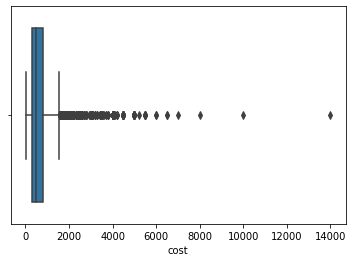

In [81]:
# Check theoutliers
sns.boxplot(df['cost'])

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf1 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
df_title = tf1.fit_transform(df['title'])
df_title = pd.DataFrame(data=df_title.toarray(), columns=tf1.get_feature_names())

tf2 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
df_cuisines = tf2.fit_transform(df['cuisines'])
df_cuisines = pd.DataFrame(data=df_cuisines.toarray(), columns=tf2.get_feature_names())

tf3 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
df_city = tf3.fit_transform(df['city'])
df_city = pd.DataFrame(data=df_city.toarray(), columns=tf3.get_feature_names())

tf4 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
df_locality = tf4.fit_transform(df['locality'])
df_locality = pd.DataFrame(data=df_locality.toarray(), columns=tf4.get_feature_names())

tf5 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
df_time = tf5.fit_transform(df['time'])
df_time = pd.DataFrame(data=df_time.toarray(), columns=tf5.get_feature_names())

In [83]:
df.head()

,title,cuisines,time,city,locality,rating,votes,cost,closed,city_mean_rating,locality_mean_rating
0,CASUAL DINING,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49.0,1200.0,NA,3.376271,3.388889
1,"CASUAL DINING,BAR","Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30.0,1500.0,NA,3.584588,3.472222
2,CASUAL DINING,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221.0,800.0,NA,3.584588,3.550000
3,QUICK BITES,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24.0,800.0,NA,3.697880,3.721622
4,DESSERT PARLOR,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165.0,300.0,NA,3.697880,3.986420


In [84]:
# Remove unused columns

In [85]:
df = pd.concat([df, df_title, df_cuisines, df_city, df_locality, df_time], axis=1) 
df.drop(['title', 'cuisines', 'city', 'locality', 'time'], axis=1, inplace=True)

In [86]:
df = pd.get_dummies(df, columns=['closed'], drop_first=True)

In [87]:
df.shape

(16921, 2339)

In [88]:
train_df = df[df['cost'].isnull()!=True]
test_df = df[df['cost'].isnull()==True]
test_df.drop('cost', axis=1, inplace=True)

In [89]:
train_df.shape, test_df.shape

((12690, 2339), (4231, 2338))

In [90]:
# Check the skewwness 
train_df.skew()

rating                        -1.875624
votes                         14.522617
cost                           3.978801
city_mean_rating              -2.382833
locality_mean_rating          -2.040968
                                ...    
closed_0.6065625780328759    112.649900
closed_0.6229996528200331    112.649900
closed_0.6395373422060688    112.649900
closed_0.6693094597549367    112.649900
closed_0.6778722496514116    112.649900
Length: 2339, dtype: float64

In [91]:
# Remove the skewness
train_df['cost'] = np.log1p(train_df['cost'])

In [92]:
train_df['votes'] = np.log1p(train_df['votes'])

In [93]:
train_df['cost'].skew()

0.39714937830985364

# Train Test split 

In [94]:
X = train_df.drop(labels=['cost'], axis=1)
y = train_df['cost'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [95]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
X = s.fit_transform(X)

In [96]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9517, 2338), (9517,), (3173, 2338), (3173,))

# Models 

## Bagging Regressor 

In [97]:
from sklearn.ensemble import BaggingRegressor
br = BaggingRegressor(base_estimator=None, 
                      n_estimators=80,  
                      max_samples=1.0, 
                      max_features=1.0, 
                      bootstrap=True, 
                      bootstrap_features=True,
                      oob_score=True,
                      n_jobs=None, 
                      random_state=13, 
                      verbose=0)
br.fit(X_train, y_train)
y_pred3 = br.predict(X_test)
print('RMSLE:', sqrt(mean_squared_log_error(y_test, y_pred3)))
print('RMSE:', sqrt(mean_squared_error(y_test, y_pred3)))

RMSLE: 0.05113807968972529
RMSE: 0.356140195791174


# Random Forest Regressor 

In [98]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=29,  
                           criterion='mse', 
                           max_depth=58,  
                           min_samples_split=5, 
                           min_samples_leaf=2, 
                           min_weight_fraction_leaf=0.0, 
                           max_features='auto', 
                           max_leaf_nodes=None, 
                           min_impurity_decrease=0.20,  
                           bootstrap=True, 
                           oob_score=True, 
                           n_jobs=-1, 
                           random_state=11)  
rf.fit(X_train, y_train)
y_pred4 = rf.predict(X_test)
print('RMSLE:', sqrt(mean_squared_log_error(y_test, y_pred4)))
print('RMSE:', sqrt(mean_squared_error(y_test, y_pred4)))

RMSLE: 0.09889588087731874
RMSE: 0.714260540109632


# Gradient Boosting Regressor

In [99]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(loss='lad', 
                               learning_rate=0.2,  
                               random_state=10, 
                               n_estimators=92,   
                               max_depth=11,  
                               subsample=1.0, 
                               min_samples_split=40, 
                               min_samples_leaf=1,
                               max_features='auto')
gb.fit(X_train, y_train)
y_pred2 = gb.predict(X_test)
print('RMSLE:', sqrt(mean_squared_log_error(y_test, y_pred2)))
print('RMSE:', sqrt(mean_squared_error(y_test, y_pred4)))

RMSLE: 0.05196636657588763
RMSE: 0.714260540109632


# Light Gradient Boostin Machine 




In [108]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

param = {'objective': 'regression',
         'boosting': 'dart',
         'num_iterations': 152,   
         'learning_rate': 0.1,  
         'num_leaves': 52, 
         'max_depth': 28, 
         'min_data_in_leaf': 3, 
         'feature_fraction': 0.66,  
         'feature_fraction_seed': 10,
         'drop_seed': 4,
         'alpha': 100,
         'max_bin': 7,
         'min_data_in_bin': 45,   
         'metric': 'l2_root'
         }

lgbm = lgb.train(params=param,
                 verbose_eval=0,
                 train_set=train_data,
                 valid_sets=[test_data])

y_pred1 = lgbm.predict(X_test)
print('RMSLE:', sqrt(mean_squared_log_error(y_test, y_pred1)))
print('RMSE:', sqrt(mean_squared_error(y_test, y_pred1)))

RMSLE: 0.12684719587389384
RMSE: 0.875367414357291


# Conclusion 
After observing all the models you can conlude that LIght Gradient Boosting machine is the best model for train and test.And even Random Forest too.

In [109]:
import joblib
joblib.dump(y_pred1,'food_cost.pkl')

['food_cost.pkl']